In [1]:
%pip install transformer_lens

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from transformer_lens import HookedEncoderDecoder
import transformer_lens.utils as utils
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformer_lens.loading_from_pretrained import OFFICIAL_MODEL_NAMES

import torch

torch.set_grad_enabled(False)


c:\Users\adigr\OneDrive\Desktop\Adi\Technion\Transformers\Project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the Model in TransformerLens

Please download the model first: https://cloud.anja.re/s/Qpo8CZ6yRzDH7ZF

In [12]:
# !wget "https://cloud.anja.re/s/qckH8GQPyN6YK8w/download?path=%2F&files=DSI-large-TriviaQA.zip"
# !unzip "download?path=%2F&files=DSI-large-TriviaQA.zip"
checkpoint = "DSI-large-TriviaQA"

OFFICIAL_MODEL_NAMES.append(checkpoint)

hf_model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
device = utils.get_device()
model = HookedEncoderDecoder.from_pretrained(checkpoint, hf_model=hf_model, device=device)

tokenizer_t5 = AutoTokenizer.from_pretrained('google-t5/t5-large')


# Our model has a new token for each document id that we trained it on.

# token id of first document that was added
first_added_doc_id = len(tokenizer_t5)
# token id of the last document that was added
last_added_doc_id = len(tokenizer_t5) + (len(tokenizer) - len(tokenizer_t5))
del tokenizer_t5


If using T5 for interpretability research, keep in mind that T5 has some significant architectural differences to GPT. The major one is that T5 is an Encoder-Decoder modelAlso, it uses relative positional embeddings, different types of Attention (without bias) and LayerNorm


Loaded pretrained model DSI-large-TriviaQA into HookedTransformer


## Examining the activations

The activations of each component in the transformer are stored in the `cache` object. It's basically a dict from which you choose which component to look at.


mlp_hook_out:

Location: This hook is typically placed at the very end of the MLP block, just before its output is potentially added back to the residual stream (after the final linear transformation within the MLP).
Meaning: This gives you the final output of the MLP before it's combined with other elements of the transformer block.

mlp_hook_post

Location: This hook is typically placed after the non-linearity.
Meaning: After the input to the MLP has been projected to a higher dimension and then passed through an activation function, mlp_hook_post would give you access to these activated, higher-dimensional features. This is often described as "post-non-linearity."

In [49]:
# Import activations per layer
all_activations = {}
pre_activations = {}
post_activations = {}
out_activations = {}

for layer in range(18, 24):
    all_activations[layer] = torch.load(f"layer_activations_no_test\layer_{layer}.json") 
    all_pre, all_post, all_out = [], [], []
    for query, query_dict in all_activations[layer].items():
        for hook_type, activation_values in query_dict.items():
            match hook_type:
                case 'pre':
                    all_pre.append(activation_values)
                case 'post':
                    all_post.append(activation_values)
                case 'out':
                    all_out.append(activation_values)
    pre_activations[layer] = all_pre
    post_activations[layer] = all_post
    out_activations[layer] = all_out


In [46]:
# number of docIDs
ids_with_more_than_threshold_correct_queries = torch.load(f"data_dictioneries\ids_with_more_than_threshold_correct_queries.json", weights_only=False)
number_of_doc_ids = len(ids_with_more_than_threshold_correct_queries)

In [53]:
# queries -> dociID mapping
queries_to_correct_preficted_ids = torch.load(f"data_dictioneries\queries_to_correct_predicted_ids.json", weights_only=False)
queries_to_correct_preficted_ids

{'QTrain22137': {1: '14575'},
 'QTrain4318': {2: '68215', 4: '65676'},
 'QTrain42646': {1: '15703'},
 'QTrain6778': {1: '48817', 2: '23966', 3: '22979'},
 'QVal7653': {1: '14268', 2: '71660'},
 'QTrain57133': {1: '66553'},
 'QTrain50965': {1: '6889', 2: '35378'},
 'QTrain46012': {1: '4456', 2: '29480'},
 'QTrain50298': {1: '5163', 2: '44813', 3: '48978'},
 'QTrain36385': {1: '17254', 2: '68980', 3: '73744', 4: '26113'},
 'QTrain15930': {1: '5274'},
 'QTrain13492': {1: '535'},
 'QTrain39606': {1: '33534', 2: '57375'},
 'QTrain19273': {1: '59903', 2: '52457', 3: '66156'},
 'QTrain2159': {1: '4318'},
 'QTrain34352': {1: '33811'},
 'QTrain2078': {1: '9490'},
 'QTrain4116': {1: '21280', 3: '57355'},
 'QTrain20689': {1: '50896', 2: '31454'},
 'QTrain6406': {1: '47849', 2: '44797'},
 'QVal2032': {1: '36924', 3: '50826', 4: '59957'},
 'QTrain21803': {1: '41337', 2: '2924', 3: '67573'},
 'QTrain15251': {1: '2415'},
 'QTrain18522': {1: '39709'},
 'QTrain9764': {1: '54526', 2: '16308'},
 'QTrain5

Kmeans

In [ ]:
#%pip install scikit-learn
#%pip install matplotlib

from collections import defaultdict
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch, numpy as np, matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def run_kmeans(tag):
    for layer in range(23, 24):
        match hook_type:
            case 'post':
                activations = post_activations[layer]
            case 'out':
                activations = out_activations[layer]
                
        # Apply K-Means (example: 10 clusters, shuold be changed to number of docID with corrected_queries)
        kmeans = KMeans(n_clusters=number_of_doc_ids, n_init=20, random_state=0)
        kmeans_labels = kmeans.fit_predict(activations)
        
        cluster_indices = defaultdict(list)
        # For each key cluster, the values are tuples of query index and its docIds 
        queries = list(all_activations[layer].keys())
        for i, cluster_label in enumerate(kmeans_labels):
            query = queries[i]
            query_doc_ids = []
            for key in queries_to_correct_preficted_ids[query]:
                for nested_key in queries_to_correct_preficted_ids[query][key]:
                    query_doc_ids.append(queries_to_correct_preficted_ids[query][key][nested_key])
            cluster_indices[cluster_label].append((i, query_doc_ids))

        pca = PCA(n_components=2, random_state=0)
        acts_2d = pca.fit_transform(activations.squeeze(1))
        cent_2d = pca.transform(kmeans.cluster_centers_)

        plt.figure(figsize=(7,5))
        sc = plt.scatter(acts_2d[:,0], acts_2d[:,1], c=kmeans_labels, s=18, cmap="viridis")
        plt.scatter(cent_2d[:,0], cent_2d[:,1], marker="X", c="red", s=5, label="centroids")
        plt.title(f"K-means (post) layer {layer}")
        plt.xlabel("PC-1"); plt.ylabel("PC-2"); plt.legend(*sc.legend_elements()); plt.show()

        # # TSNE
        # acts_tsne = TSNE(n_components=2, random_state=0, perplexity=30).fit_transform(activations.squeeze(1))
        # centroids_tsne = np.array([
        #     acts_tsne[kmeans_labels == i].mean(axis=0)
        #     for i in range(number_of_doc_ids)
        # ])
        # plt.figure(figsize=(7,5))
        # sc = plt.scatter(acts_tsne[:,0], acts_tsne[:,1], c=kmeans_labels, s=18, cmap="viridis")
        # plt.scatter(centroids_tsne[:,0], centroids_tsne[:,1], marker="X", c="red", s=50, label="centroids")
        # plt.title(f"K-means (t-SNE) layer {layer}")
        # plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
        # plt.legend(*sc.legend_elements())
        # plt.show()

        # # purity check 
        # # majority docID inside each cluster vs total items - might reveal how explicitly each layer encodes document-level information
        # doc_ids = [q[2] for q in correct_queries]
        # correct = sum(max(np.bincount([d for _, d in lst])) for lst in cluster_indices.values())
        # purity  = correct / len(doc_ids)
        # print(f"Layer {layer}: purity={purity:.3f}")

run_kmeans("post")  
# run_kmeans("out")

39958 1024


KeyboardInterrupt: 

21.727028901120928
[post] layer 18: 53 clusters, 1450 noise points
purity=0.078


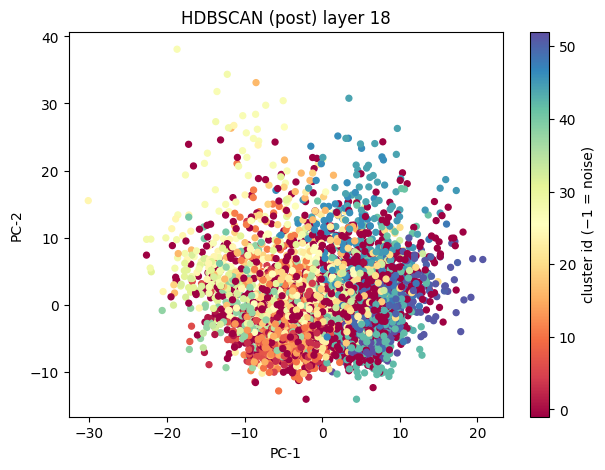

16.739048049345413
[post] layer 19: 45 clusters, 1453 noise points
purity=0.070


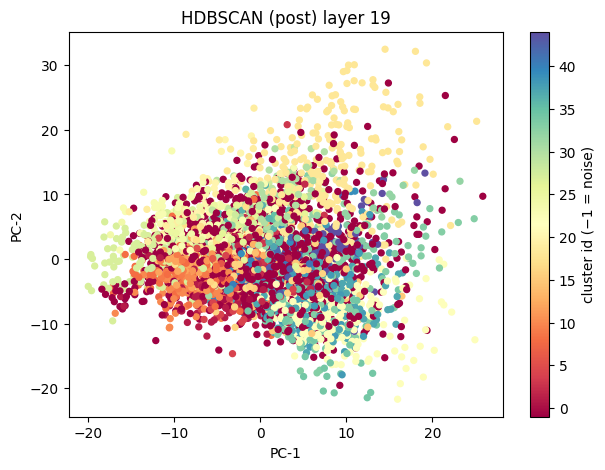

17.018005149500024
[post] layer 20: 49 clusters, 1351 noise points
purity=0.078


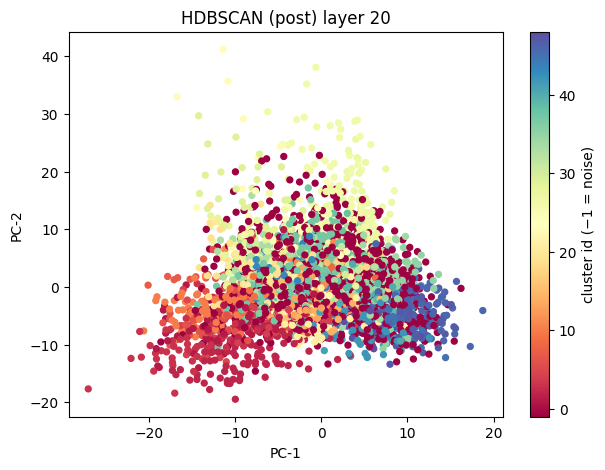

15.60318600876781
[post] layer 21: 46 clusters, 1453 noise points
purity=0.077


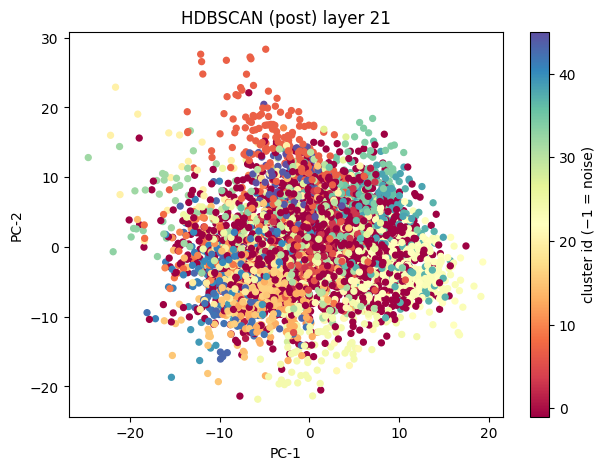

15.744793472992916
[post] layer 22: 49 clusters, 1325 noise points
purity=0.079


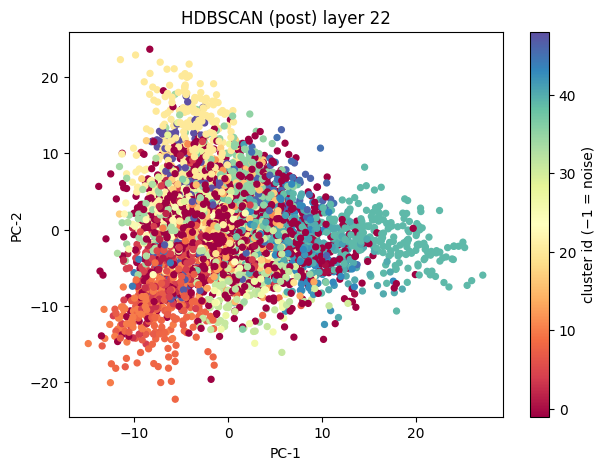

19.209833589397256
[post] layer 23: 55 clusters, 1381 noise points
purity=0.087


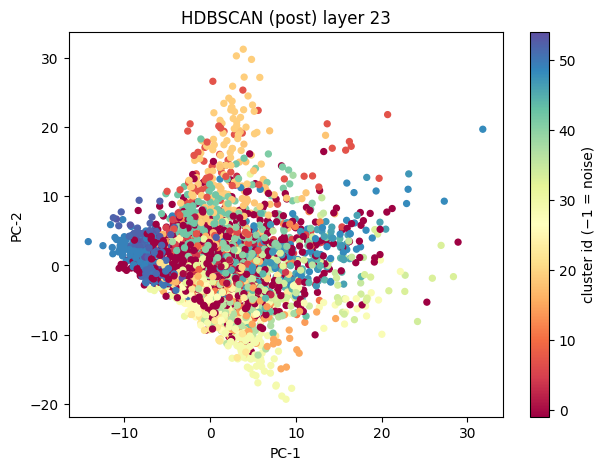

In [ ]:
#%pip install hdbscan 
#%pip install umap-learn
#%pip install scikit-dimension

import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib.pyplot as plt
from collections import defaultdict
import skdim.id

def run_hdbscan(cached_dict, tag, min_cluster_size_ratio=0.005, min_samples=3): # sophisticated density-based clustering pipeline
    for layer in range(18, 24):

        acts = cached_dict[f"layer_{layer}"].squeeze(1).cpu().numpy()

        acts_std = StandardScaler().fit_transform(acts) # StandardScaler transforms each feature to have zero mean and unit variance
 
        # Apply UMAP for dimensionality reduction - UMAP (Uniform Manifold Approximation and Projection) is a non-linear dimensionality 
        # reduction technique that addresses the curse of dimensionality
            #n_components = min(15, acts_std.shape[0] - 1)  # avoid n_components > samples (tried first 50)  
        # Set n_components based on intrinsic dimension
        intrinsic_dim = skdim.id.TwoNN().fit(acts_std).dimension_
        print(intrinsic_dim)
        n_components = int(np.clip(round(intrinsic_dim), 2, 1000))
        reducer = UMAP(n_components=200, n_neighbors=30, min_dist=0.1, metric='cosine', random_state=42) # (treis first n_neighbors=30)
        acts_reduced = reducer.fit_transform(acts_std)

        min_cluster_size = max(5, int(len(acts_reduced) * min_cluster_size_ratio)) # This adaptive parameter setting ensures that cluster size requirements scale with dataset size. 
        # Run HDBSCAN
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            metric='euclidean',  # or 'cosine' if preferred
            prediction_data=True
        )
        
        labels = clusterer.fit_predict(acts_reduced)

        # Count clusters and noise
        n_clust = len(set(labels)) - (1 if -1 in labels else 0)
        print(f"[{tag}] layer {layer}: {n_clust} clusters, {(labels==-1).sum()} noise points")

        # Compute purity - measures clustering quality by calculating the fraction of data points that belong to the correct cluster
        clusters = defaultdict(list)
        for i, cl in enumerate(labels):
            clusters[cl].append(doc_ids[i])
        if n_clust:
            pure = sum(max(np.bincount(docs)) for cl, docs in clusters.items() if cl != -1)
            purity = pure / len(doc_ids)
            print(f"purity={purity:.3f}")
        else:
            print("No clusters found, purity not computed.")

        # Visualize in 2D
        acts_2d = PCA(n_components=2, random_state=0).fit_transform(acts_std)
        plt.figure(figsize=(7,5))
        sc = plt.scatter(acts_2d[:,0], acts_2d[:,1], c=labels, cmap="Spectral", s=18)
        plt.title(f"HDBSCAN ({tag}) layer {layer}")
        plt.xlabel("PC-1"); plt.ylabel("PC-2")
        plt.colorbar(sc, label="cluster id (−1 = noise)")
        plt.show()

run_hdbscan(cached_mlp_post, "post")
# run_hdbscan(cached_mlp_out, "out")

Community Detection 

In [ ]:
#%pip install python-louvain
import community as co  


In [ ]:
for key in cache.keys():
  if key.startswith('decoder.0.'):
    print(key)

decoder.0.hook_resid_pre
decoder.0.ln1.hook_scale
decoder.0.ln1.hook_normalized
decoder.0.attn.hook_q
decoder.0.attn.hook_k
decoder.0.attn.hook_v
decoder.0.attn.hook_attn_scores
decoder.0.attn.hook_pattern
decoder.0.attn.hook_z
decoder.0.hook_attn_out
decoder.0.hook_resid_mid
decoder.0.ln2.hook_scale
decoder.0.ln2.hook_normalized
decoder.0.cross_attn.hook_q
decoder.0.cross_attn.hook_k
decoder.0.cross_attn.hook_v
decoder.0.cross_attn.hook_attn_scores
decoder.0.cross_attn.hook_pattern
decoder.0.cross_attn.hook_z
decoder.0.hook_cross_attn_out
decoder.0.hook_resid_mid_cross
decoder.0.ln3.hook_scale
decoder.0.ln3.hook_normalized
decoder.0.mlp.hook_pre
decoder.0.mlp.hook_post
decoder.0.hook_mlp_out
decoder.0.hook_resid_post


We choose to look at the output of the MLP in layer 19 of the decoder:

In [ ]:
cache['decoder.19.hook_mlp_out'], cache['decoder.19.hook_mlp_out'].shape

(tensor([[[-1.4089e+02, -2.0473e+02, -5.6433e-02,  ...,  4.9263e+01,
           -8.4219e+01,  1.5536e+02]],
 
         [[ 7.2566e+00, -5.0493e+01, -1.2412e+02,  ...,  1.4575e+02,
            6.8565e+01,  1.5717e+01]],
 
         [[ 6.6459e+01, -1.9917e+01, -1.6834e+02,  ...,  5.7672e+01,
           -5.3799e+01,  1.2615e+01]],
 
         ...,
 
         [[ 1.1922e+02, -1.2897e+02,  7.9998e+01,  ...,  9.5135e+01,
            7.0183e+01,  3.8647e+01]],
 
         [[ 5.6096e+01,  7.7733e+01, -7.3603e+01,  ...,  1.2690e+02,
            3.5836e+01, -3.5754e+01]],
 
         [[-1.1233e+02, -1.1624e+02, -1.0520e+02,  ...,  6.6645e+01,
           -1.5988e+02,  6.4129e+01]]]),
 torch.Size([10, 1, 1024]))